In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 32

In [3]:
load_data = tf.keras.preprocessing.image_dataset_from_directory(
    r"D:\keer project\pest\pest ds",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3246 files belonging to 18 classes.


In [4]:
class_names = load_data.class_names
class_names


['Aulacophora',
 'Bactrocera cucurbitae',
 'Caterpillar',
 'Dark evening',
 'Longitarsus',
 'Pentatomomorpha',
 'Planococcus lilacinus',
 'Scirpophaga',
 'Weevil',
 'aphids',
 'armyworm',
 'beetle',
 'bollworm',
 'grasshopper',
 'mites',
 'mosquito',
 'sawfly',
 'stem_borer']

In [5]:
len(load_data)

102

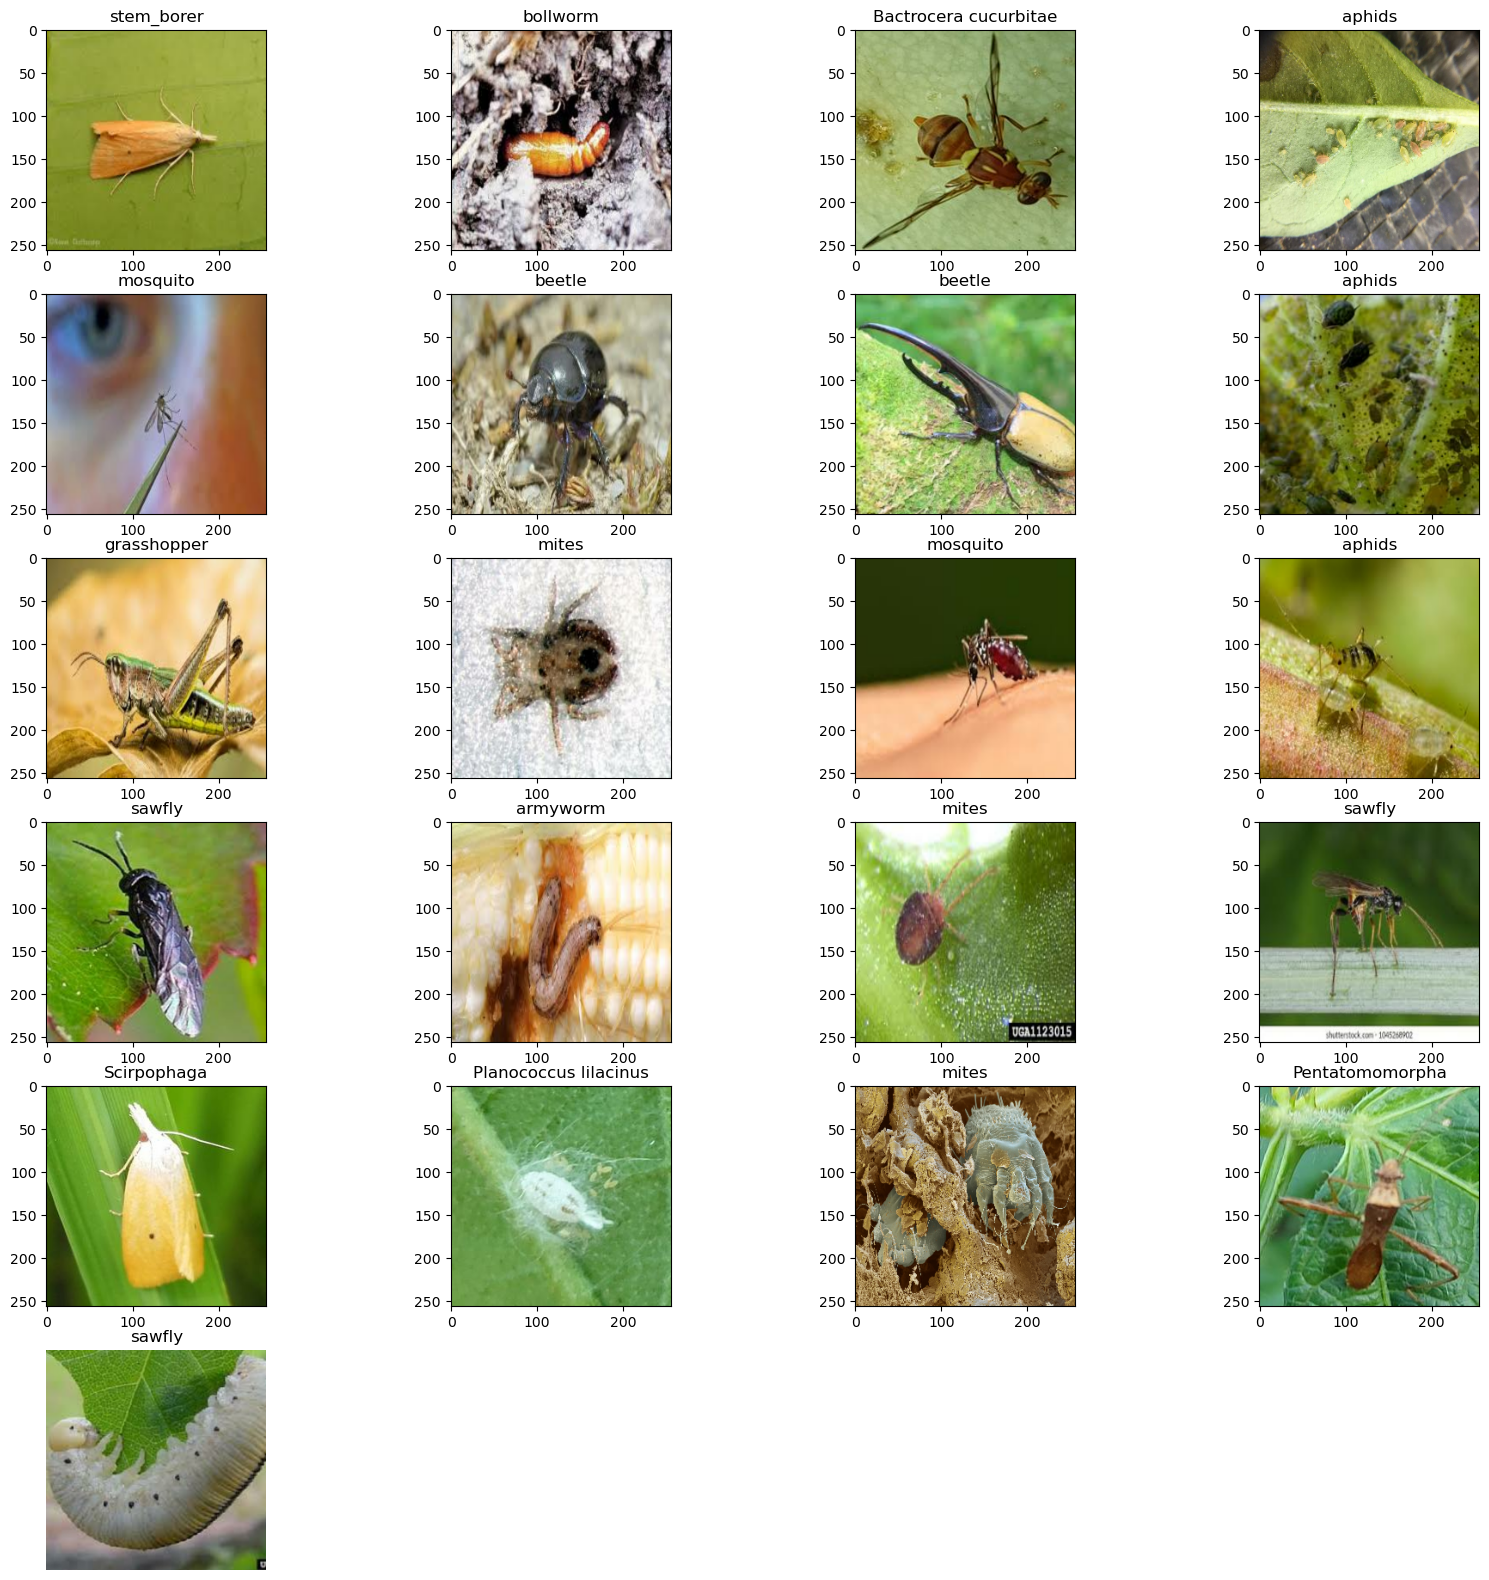

In [6]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in load_data.take(1):
    for i in range(0,21):
        plt.subplot(6,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [7]:
def get_dataset_partition_tf(data,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    data_size=len(data)
    if shuffle:
        data=data.shuffle(shuffle_size,seed=32)
    train_size=int(train_split*data_size)
    val_size=int(val_split*data_size)
    train_data=data.take(train_size)
    
    val_data=data.skip(train_size).take(val_size)
    test_data=data.skip(train_size).skip(val_size)
    return train_data,val_data,test_data

In [8]:
train_data,val_data,test_data=get_dataset_partition_tf(load_data)

In [9]:
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale =tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255)])

In [11]:
data_augmentation =tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)])

In [12]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)

overall_model = models.Sequential([
    resize_and_rescale,data_augmentation,
    layers.Conv2D(64,(3,3),activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(len(class_names),activation='softmax')

])

In [13]:
overall_model.build(input_shape=input_shape)

In [14]:
overall_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [15]:
overall_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [16]:
history=overall_model.fit(
    train_data,
    epochs=10,
    batch_size=32,
    verbose=1,
    validation_data=val_data
)

Epoch 1/10
81/81 [==============================] - 175s 2s/step - loss: 2.5457 - accuracy: 0.1639 - val_loss: 2.3267 - val_accuracy: 0.2438
Epoch 2/10
81/81 [==============================] - 159s 2s/step - loss: 2.2888 - accuracy: 0.2479 - val_loss: 2.1909 - val_accuracy: 0.2500
Epoch 3/10
81/81 [==============================] - 155s 2s/step - loss: 2.0105 - accuracy: 0.3271 - val_loss: 1.8635 - val_accuracy: 0.3594
Epoch 4/10
81/81 [==============================] - 157s 2s/step - loss: 1.7589 - accuracy: 0.4161 - val_loss: 1.6639 - val_accuracy: 0.4563
Epoch 5/10
81/81 [==============================] - 154s 2s/step - loss: 1.5439 - accuracy: 0.4794 - val_loss: 1.4000 - val_accuracy: 0.5188
Epoch 6/10
81/81 [==============================] - 156s 2s/step - loss: 1.3781 - accuracy: 0.5350 - val_loss: 1.1378 - val_accuracy: 0.6438
Epoch 7/10
81/81 [==============================] - 155s 2s/step - loss: 1.1547 - accuracy: 0.6088 - val_loss: 0.9962 - val_accuracy: 0.7000
Epoch 8/10
81

In [17]:
scores = overall_model.evaluate(test_data)

11/11 [==============================] - 9s 393ms/step - loss: 0.5766 - accuracy: 0.8381


In [18]:
scores

[0.5766306519508362, 0.8380681872367859]

In [19]:
history

In [20]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 81}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
type(history.history['loss'])

list

In [23]:
len(history.history['loss'])

10

In [24]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.545687198638916,
 2.288771390914917,
 2.010505437850952,
 1.7589324712753296,
 1.5438811779022217]

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [26]:
val_acc




[0.24375000596046448,
 0.25,
 0.359375,
 0.45625001192092896,
 0.518750011920929,
 0.643750011920929,
 0.699999988079071,
 0.690625011920929,
 0.7718750238418579,
 0.8125]

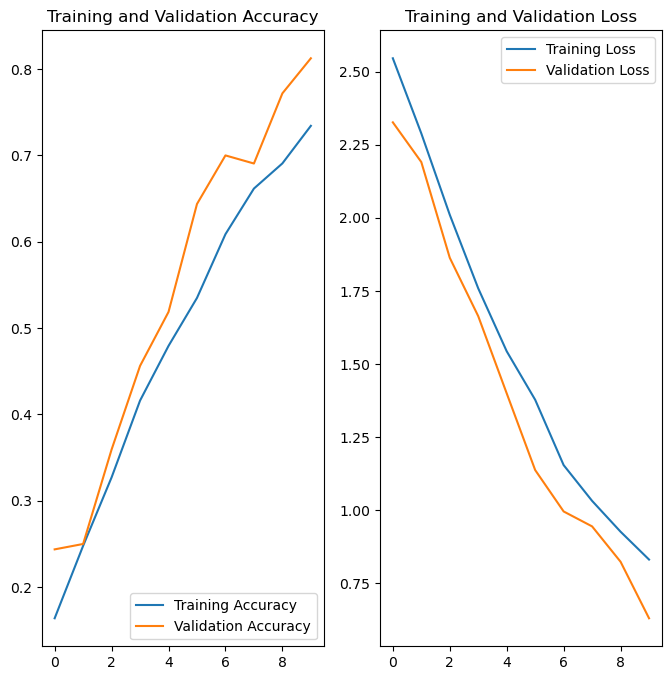

In [28]:
EPOCHS = 10

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Actual label :  armyworm
1/1 [==============================] - 1s 588ms/step
predicted label :  armyworm


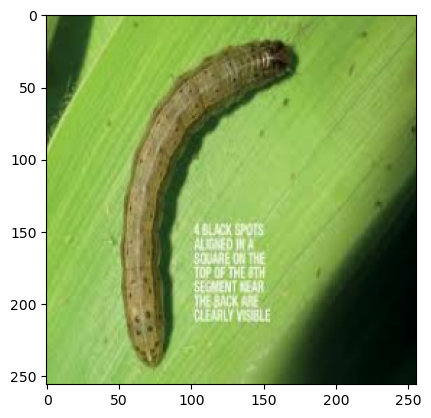

In [29]:
for image_batch,lables_batch in test_data.take(1):
    image=image_batch[0].numpy().astype("uint8")
    label=lables_batch[0].numpy()
    
    plt.imshow(image)
    print("Actual label : ",class_names[label])
    
    batch_prediction=overall_model.predict(image_batch)
    print("predicted label : ",class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict (overall_model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    prediction = overall_model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100*(np.max(prediction[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 52ms/step


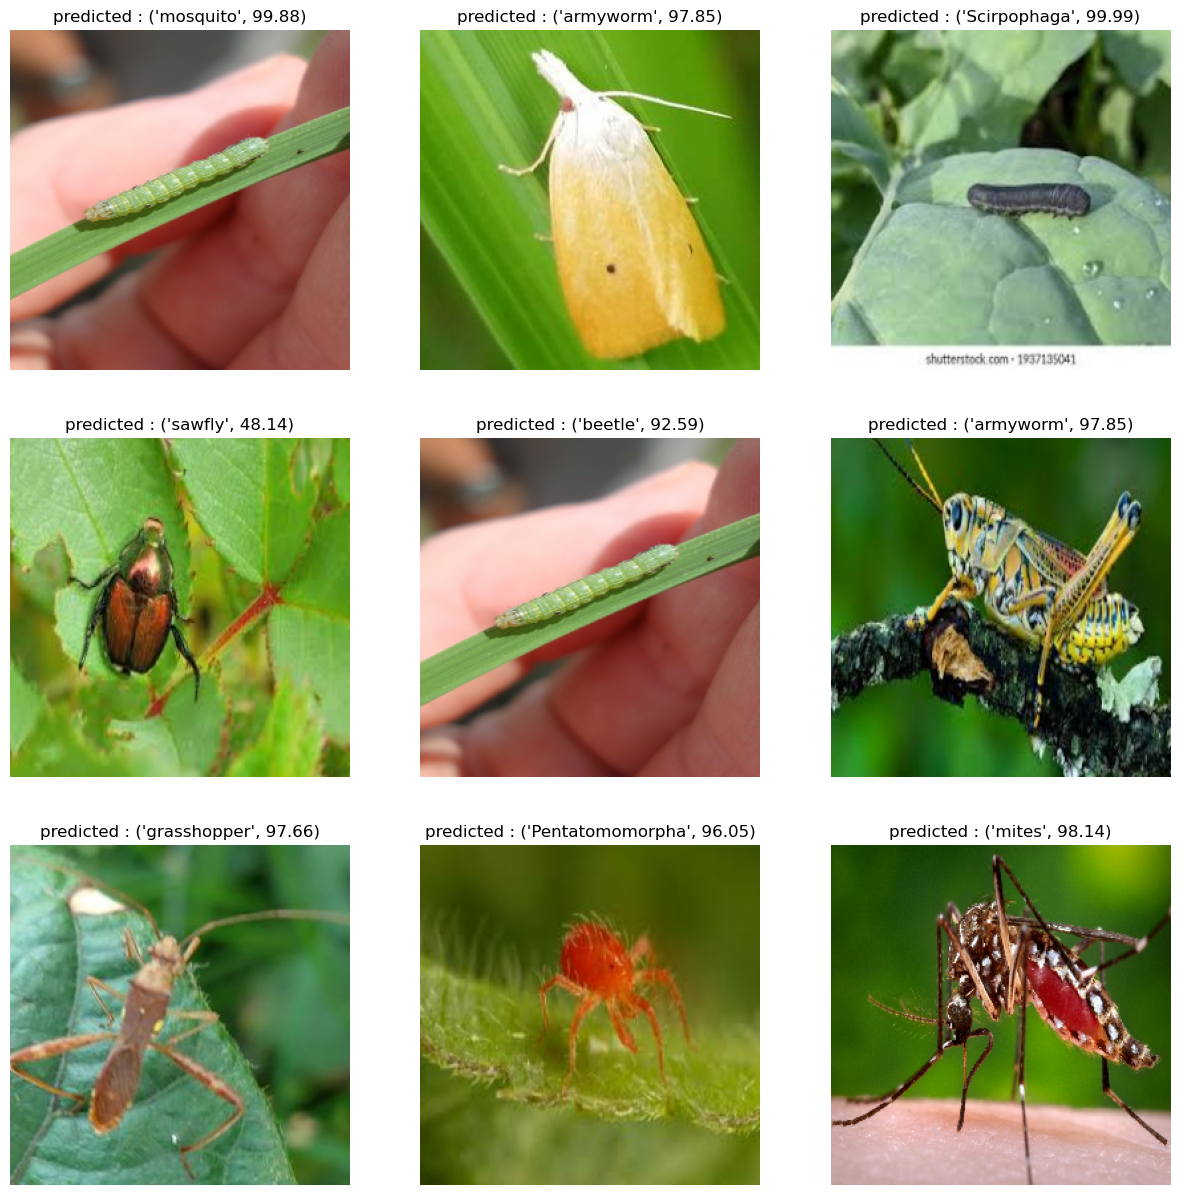

In [38]:
plt.figure(figsize=(15,15))
for image, labels in test_data:
    for i in range(9):
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.subplot(3,3,i+1)
        predicted_class= predict(overall_model,image[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title( f"predicted : {predicted_class}")
        plt.axis("off")

In [ ]:
model.save("../potatoes.h5")